# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
import hyperopt
from joblib import Parallel, delayed

# Parameters

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
spikes_file = filepath_root+'hotspots/spikes_combined_1H.csv'
time_high_file = filepath_root+'hotspots/hotspots_combined_temporalhigh_1H.pkl'
time_low_file = filepath_root+'hotspots/hotspots_combined_temporallow_1H.pkl'
space_high_file = filepath_root+'hotspots/hotspots_combined_spatialhigh_1H.pkl'
space_low_file = filepath_root+'hotspots/hotspots_combined_spatiallow_1H.pkl'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [4]:
locs

,UDID,Latitude,Longitude,Address,Location,Type
Monitor ID,,,,,,
BB4A,492457f434f94afc865bb4701990bb4a,28.554980,77.194430,Jamun,Hauz Khas Village,Kaiterra
91B8,ea3ceeefd9654dfd9aab41422f7391b8,28.503050,77.185660,Vihara,Chhatapur,Kaiterra
BC46,29b8262425cf4135899cd65b2458bc46,28.632950,77.288700,Segel Design,Preet Vihar,Kaiterra
BFDC,11047d2ddc514f63a12ad4f1ad3bbfdc,28.521083,77.214237,Arundhati,Saket,Kaiterra
D804,f083e8afd43e4727a5eb7f3a1529d804,28.558230,77.208620,EPoD,Yusuf Sarai,Kaiterra
...,...,...,...,...,...,...
Sirifort_CPCB,NaN,28.550425,77.215938,NaN,"Sirifort, New Delhi - CPCB",Govt
SoniaVihar_DPCC,NaN,28.710508,77.249485,NaN,"Sonia Vihar, Delhi - DPCC",Govt
SriAurobindoMarg_DPCC,NaN,28.531346,77.190156,NaN,"Sri Aurobindo Marg, Delhi - DPCC",Govt


# Load Hotspots

In [5]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [6]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [7]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Load Wind Speeds

In [8]:
df_ws = pd.read_csv('/scratch/ab9738/pollution_with_sensors/hotspots/source_apportionment/wind_speeds.csv', parse_dates=True)

df_ws = df_ws.sort_values(['Timestamp']).reset_index(drop=True)

df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['Timestamp']))

df_ws = df_ws[['u-component', 'v-component']].groupby('Timestamp').mean()

In [9]:
df_ws

,u-component,v-component
Timestamp,,
2018-05-01 00:00:00,-5.912000,3.205333
2018-05-01 06:00:00,-3.213333,5.312000
2018-05-01 12:00:00,-3.637333,-0.202667
2018-05-01 18:00:00,-6.544000,2.458667
2018-05-02 00:00:00,-4.949333,2.280000
...,...,...
2020-10-30 18:00:00,2.400000,-1.920000
2020-10-31 00:00:00,2.560000,-1.093333
2020-10-31 06:00:00,4.853333,-4.106667


# Load Intensity Maps

In [10]:
brick_kilns = np.load('brick_kilns_intensity_80x80.npy')
industries = np.load('industries_intensity_80x80.npy')
power_plants = np.load('power_plants_intensity_80x80.npy')
population_density = np.load('population_density_intensity_80x80.npy')
traffic_06 = np.load('traffic_06_intensity_80x80.npy')
traffic_12 = np.load('traffic_12_intensity_80x80.npy')
traffic_18 = np.load('traffic_18_intensity_80x80.npy')
traffic_00 = np.load('traffic_00_intensity_80x80.npy')

# Gaussian-Plume Model for Point Source

## Core Gaussian-Plume Dispersion Formula

In [41]:
def gaussian_plume(src, dest, intensity, H, wind_speed, alpha, z, a, c, d, f, offset):
    if(intensity>0):
        distance_direction = np.array([dest[1]-src[1], dest[0]-src[0]])/math.sqrt((dest[1]-src[1])**2+(dest[0]-src[0])**2) 
        #reversing as lat=y-axis and long=x-axis
        distance_magnitude = distance.distance(src, dest).meters
        distance_vector = distance_magnitude * distance_direction
        unit_wind_vector = wind_speed/math.sqrt(wind_speed[0]**2 + wind_speed[1]**2)
        wind_magnitude = np.linalg.norm(wind_speed)
        distance_wind = np.dot(distance_vector, unit_wind_vector)
        if(distance_wind<=0):
            return(0.0)
        distance_wind = max(distance_wind,offset)
        distance_perpendicular = np.linalg.norm(np.subtract(distance_vector, distance_wind))
        sigma_z = c*math.pow(distance_wind,d)+f
        sigma_y = a*math.pow(distance_wind,0.894)
        concentration = ((alpha*intensity)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-distance_perpendicular**2/(2*sigma_y**2))*\
        (math.exp(-(z-H)**2/(2*sigma_z**2))+math.exp(-(z+H)**2/(2*sigma_z**2)))
        return(concentration*(10**9))
    else:
        return 0

## Computing concentration at a sensor because of different sources

In [42]:
def compute_concentration(dest, ts, alpha, wind_speed, stack_height=None, z=6.5, a=213, c=459.7, d=2.094, f=-9.6, offset=100):
    if(stack_height is None):
        stack_height = {'traffic':0, 'brick_kilns':25, 'population_density':10, 'industry':30}
    
    idx_x = int((dest[1]-76.85)/0.01)
    idx_y = 79-int((dest[0]-28.2)/0.01)
    src_radius = 7
    if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
        traffic_srcs = traffic_06
    elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
        traffic_srcs = traffic_12
    elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
        traffic_srcs = traffic_18
    else:
        traffic_srcs = traffic_00
        
    contrib_brick, contrib_industry, contrib_population, contrib_traffic = 0.0,0.0,0.0,0.0
        
    for i in range(idx_y-src_radius, idx_y+src_radius+1):
        for j in range(idx_x-src_radius, idx_x+src_radius+1):
            src = (28.2+((79-j)*0.01)+0.005, 76.85+(i*0.01)+0.005)
            contrib_brick += gaussian_plume(src, dest, brick_kilns[i,j], stack_height['brick_kilns'], wind_speed, alpha['brick_kilns'],z,a,c,d,f,offset)
            contrib_industry += gaussian_plume(src, dest, industries[i,j], stack_height['industry'], wind_speed, alpha['industry'], z,a,c,d,f,offset)
            contrib_population += gaussian_plume(src, dest, population_density[i,j], stack_height['population_density'], wind_speed,\
                                                 alpha['population_density'], z,a,c,d,f,offset)
            contrib_traffic += gaussian_plume(src, dest, traffic_srcs[i,j], stack_height['traffic'], wind_speed, alpha['traffic'], z,a,c,d,f,offset)
            
    total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic
    contrib = [contrib_brick, contrib_industry, contrib_population, contrib_traffic]
    return total_concentration, contrib

## Finding all sensors near hotspot

In [43]:
def find_sensors_in_region(sensor):
    coord = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
    region_lat_b, region_lat_t, region_long_l, region_long_r = coord[0]-0.025, coord[0]+0.025, coord[1]-0.025, coord[1]+0.025
    subset_locs = locs[(locs['Latitude']<region_lat_t) & (locs['Latitude']>region_lat_b) &\
                       (locs['Longitude']<region_long_r) & (locs['Longitude']>region_long_l)]
    sensors = np.intersect1d(subset_locs.index.to_numpy(),df.columns)
    return(sensors)

## Find nearest wind speed data

In [44]:
def get_wind_speed_estimate(hsp):
    ts = np.array([hsp[0]]).astype('datetime64[ns]')[0]

    if(pd.Timestamp(ts).hour in [5,11,17,23]):
        ts = ts+np.timedelta64(30,'m')
    else:
        ts = ts-np.timedelta64(30,'m')

    ws = df_ws.loc[ts].values
    ws = ws*(5.0/18)
    return(ws)

## Filtering Hotspots based on time so that wind data is only 30 minutes in deviation.

In [15]:
ws_timestamps = df_ws.index.to_numpy()
hsp_timestamps = np.array(shsp_high)[:,0].astype('datetime64[ns]')

df_hsp_timestamps = pd.DataFrame(hsp_timestamps)

shsp_toexplain = np.array(shsp_high)[df_hsp_timestamps[0].apply(lambda x: True if x.hour in [5,6,11,12,17,18,23,0] else False).to_numpy()]

In [16]:
np.random.seed(42)
np.random.shuffle(shsp_toexplain)
train, test = shsp_toexplain[:int(0.8*len(shsp_toexplain))], shsp_toexplain[int(0.8*len(shsp_toexplain)):]

# MLE Training of Model 

In [17]:
# def obj_hsp(hsp,alpha,H,z,a,c,d,f,offset):
#     wind_speed = get_wind_speed_estimate(hsp)

#     sensors = find_sensors_in_region(hsp[1])

#     sensors = df.loc[hsp[0]][sensors].dropna().index.to_numpy() 
#     obj = 0
#     for sensor in sensors:
#         dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
#         ts = hsp[0]
#         computed_val, _ = compute_concentration(dest=dest, ts=ts, alpha=alpha, wind_speed=wind_speed, stack_height=H, z=z, \
#                                             a=a, c=c, d=d, f=f, offset=offset)
#         measured_val = df.loc[hsp[0]][sensor]
#         obj = obj + (measured_val-computed_val)**2
        
#     return(obj,len(sensors))



# def objective(params):
    
#     [alpha_traffic, alpha_brick, alpha_population, alpha_industry, H_traffic, H_brick, H_population, H_industry, offset, stability] = params
#     alpha = {'traffic':alpha_traffic, 'brick_kilns':alpha_brick, 'population_density':alpha_population, 'industry':alpha_industry}
#     H = {'traffic':H_traffic, 'brick_kilns':H_brick, 'population_density':H_population, 'industry':H_industry}
#     # stability = 'A'
#     stability_dict = {'A': [213,459.7,2.084,-9.6], 'B':[156,108.2,1.098,2.0], 'C':[104,61.0,0.911,0.0], 'D':[68,44.5,0.516,-13.0],\
#                      'E':[50.5,55.4,0.305,-34.0], 'F':[34,62.6,0.180,-48.6]}
#     [a,c,d,f] = stability_dict[stability]
#     z = 5
#     obj_sens = np.array(Parallel(n_jobs=15)(delayed(obj_hsp)(train[i],alpha,H,z,a,c,d,f,offset) for i in range(len(train))))
#     obj = np.sum(obj_sens[:,0])
#     N = np.sum(obj_sens[:,1])  
#     rmse = math.sqrt(obj/N)
#     return(rmse)

# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# space = [hp.uniform('alpha_traffic', 1, 100),hp.uniform('alpha_brick', 1, 100),hp.uniform('alpha_population', 1, 100),\
#          hp.uniform('alpha_industry', 1, 100),hp.uniform('H_traffic',0,3),hp.uniform('H_brick',20,60), hp.uniform('H_population', 0, 20),\
#         hp.uniform('H_industry', 30, 60), hp.uniform('offset',50,500), hp.choice('stability',['A','B','C','D','E','F'])]

# trials = Trials()

# best = fmin(objective, space, algo=tpe.suggest, max_evals=1000, trials=trials, trials_save_file='trials_1000.hyperopt')

# import json
# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super(NpEncoder, self).default(obj)
# with open('best_1000.json', 'w') as fp:
#     json.dump(best, fp, cls=NpEncoder)

In [18]:
# with open('best.json', 'r') as fp:
#     best = json.load(fp)

In [2]:
with open('trials_200.hyperopt', 'rb') as f:
    trials = pkl.load(f)

print(len(trials.losses()),min(trials.losses()))

idx = trials.losses().index(min(trials.losses()))
best_list_dict = trials.trials[idx]['misc']['vals']
best = {key:value[0] for key,value in best_list_dict.items()}
best

200 389.4259287770188


{'H_brick': 41.00033142465222,
 'H_industry': 59.9874374851038,
 'H_population': 19.19411062279148,
 'H_traffic': 0.44813303775991253,
 'alpha_brick': 49.3120662405853,
 'alpha_industry': 95.97471945543356,
 'alpha_population': 99.53279118662374,
 'alpha_traffic': 79.2921648441604,
 'offset': 100.76721012494184,
 'stability': 0}

# Evaluation of Gaussian Plume Model

In [46]:
def evaluate(params):
    
    alpha_traffic = params['alpha_traffic']
    alpha_brick = params['alpha_brick']
    alpha_population = params['alpha_population']
    alpha_industry = params['alpha_industry']
    H_traffic = params['H_traffic']
    H_brick = params['H_brick']
    H_population = params['H_population']
    H_industry = params['H_industry']
    offset = params['offset']
    z = 5
    stability = ['A','B','C','D','E','F'][0]
    
    H = {'traffic':H_traffic, 'brick_kilns':H_brick, 'population_density':H_population, 'industry':H_industry,}
    alpha = {'traffic':alpha_traffic, 'brick_kilns':alpha_brick, 'population_density':alpha_population, 'industry':alpha_industry}
    stability_dict = {'A': [213,459.7,2.084,-9.6], 'B':[156,108.2,1.098,2.0], 'C':[104,61.0,0.911,0.0], 'D':[68,44.5,0.516,-13.0],\
                     'E':[50.5,55.4,0.305,-34.0], 'F':[34,62.6,0.180,-48.6]}
    [a,c,d,f] = stability_dict[stability]
    
    phase = test
    
    obj, N = 0, 0
    explained = 0
    chsp, mhsp = [],[]
    for i in tqdm(range(len(phase))):

        hsp = phase[i]

        wind_speed = get_wind_speed_estimate(hsp)
        sensors = find_sensors_in_region(hsp[1])
        sensors = df.loc[hsp[0]][sensors].dropna().index.to_numpy()
        comp, meas = {},{}

        for sensor in sensors:
            dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
            ts = hsp[0]
            computed_val, _ = compute_concentration(dest=dest, ts=ts, alpha=alpha, wind_speed=wind_speed, stack_height=H, z=z, \
                                                a=a, c=c, d=d, f=f, offset=offset)
            measured_val = df.loc[hsp[0]][sensor]
            obj = obj + (measured_val-computed_val)**2
            N = N+1
            comp[sensor] = computed_val
            meas[sensor] = measured_val
            
        if(np.argmax(np.array(list(comp.values())))==np.argmax(np.array(list(meas.values())))):
            explained = explained + 1
        
        chsp.append(comp)
        mhsp.append(meas)
            
    rmse = math.sqrt(obj/N)
    return(rmse, explained, len(phase), chsp, mhsp)

In [47]:
rmse, explained, total, chsp, mhsp = evaluate(best)

100%|██████████| 398/398 [00:48<00:00,  8.25it/s]


In [48]:
print(rmse, explained, total)

392.5423460047817 250 398


In [49]:
explained/total

0.628140703517588

In [103]:
for i in range(len(chsp)):
    if(max(chsp[i], key=chsp[i].get)==max(mhsp[i], key=mhsp[i].get)):
        print(i,chsp[i],mhsp[i])

0 {'8E2A': 0.1520740003526512, 'AyaNagar_IMD': 0.13995631212350848} {'8E2A': 253.75, 'AyaNagar_IMD': 88.12}
1 {'C0A7': 6.727959918603021e-06} {'C0A7': 247.33333333333331}
5 {'DwarkaSector8_DPCC': 6.076664300299292e-05} {'DwarkaSector8_DPCC': 668.25}
8 {'DKSSR_DPCC': 1.3259301973491764} {'DKSSR_DPCC': 282.75}
11 {'Jahangirpuri_DPCC': 13.08354265785805} {'Jahangirpuri_DPCC': 353.0}
12 {'AnandVihar_DPCC': 5.263026284692856} {'AnandVihar_DPCC': 467.5}
13 {'IGIAirport_IMD': 0.0} {'IGIAirport_IMD': 247.62}
14 {'72CA': 17.688906376123672} {'72CA': 517.9166666666666}
16 {'Mundaka_DPCC': 0.0028698157507050506} {'Mundaka_DPCC': 464.5}
19 {'AshokVihar_DPCC': 4.807222754452011, 'Wazirpur_DPCC': 11.210934798247857} {'AshokVihar_DPCC': 351.0, 'Wazirpur_DPCC': 481.25}
20 {'Jahangirpuri_DPCC': 2.8231488948919803} {'Jahangirpuri_DPCC': 389.0}
21 {'AshokVihar_DPCC': 9.68815807023041, 'Wazirpur_DPCC': 11.63043168708608} {'AshokVihar_DPCC': 392.5, 'Wazirpur_DPCC': 436.5}
23 {'PunjabiBagh_DPCC': 1.65619928

# Mapping and Source Apportionment of Hotspots

In [138]:
def map_apportion_hotspot(params, hsp):
    alpha_traffic = params['alpha_traffic']
    alpha_brick = params['alpha_brick']
    alpha_population = params['alpha_population']
    alpha_industry = params['alpha_industry']
    H_traffic = params['H_traffic']
    H_brick = params['H_brick']
    H_population = params['H_population']
    H_industry = params['H_industry']
    offset = params['offset']
    z = 5
    stability = ['A','B','C','D','E','F'][0]
    
    H = {'traffic':H_traffic, 'brick_kilns':H_brick, 'population_density':H_population, 'industry':H_industry,}
    alpha = {'traffic':alpha_traffic, 'brick_kilns':alpha_brick, 'population_density':alpha_population, 'industry':alpha_industry}
    stability_dict = {'A': [213,459.7,2.084,-9.6], 'B':[156,108.2,1.098,2.0], 'C':[104,61.0,0.911,0.0], 'D':[68,44.5,0.516,-13.0],\
                     'E':[50.5,55.4,0.305,-34.0], 'F':[34,62.6,0.180,-48.6]}
    [a,c,d,f] = stability_dict[stability]
    
    wind_speed = get_wind_speed_estimate(hsp)
    sensor = hsp[1]
    dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
    ts = hsp[0]
    computed_val, contributions = compute_concentration(dest=dest, ts=ts, alpha=alpha, wind_speed=wind_speed, stack_height=H, z=z, \
                                        a=a, c=c, d=d, f=f, offset=offset)
    measured_val = df.loc[hsp[0]][sensor]
    inc = measured_val/computed_val
    
    region_lat_b, region_lat_t, region_long_l, region_long_r = dest[0]-0.025, dest[0]+0.025, dest[1]-0.025, dest[1]+0.025
    
    res = 0
    map_hsp = np.zeros((res,res))
    for i in tqdm(range(res)):
        for j in range(res):
            lat = region_lat_b + (region_lat_t-region_lat_b)*((res-j-1)*1.0/res)
            long = region_long_l + (region_long_r - region_long_l)*(i*1.0/res)
            cord = (lat,long)
            val, _ = compute_concentration(dest=cord, ts=ts, alpha=alpha, wind_speed=wind_speed, stack_height=H, z=z, \
                                        a=a, c=c, d=d, f=f, offset=offset)
            map_hsp[i,j] = val
    return(map_hsp, contributions)

In [158]:
test_subset = shsp_toexplain[shsp_toexplain[:,1]=='RKPuram_DPCC']
for i in range(len(test_subset)):
    _, apportionment = map_apportion_hotspot(best, test_subset[i])
    if(sum(apportionment)):
        print(test_subset[i])
        apportionment = apportionment/sum(apportionment)
        apportionment = apportionment*100
        print('contrib_brick', round(apportionment[0],2), 'contrib_industry', round(apportionment[1],2),\
              'contrib_population', round(apportionment[2],2), 'contrib_traffic', round(apportionment[3],2))

0it [00:00, ?it/s]


[Timestamp('2019-02-04 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.26 contrib_industry 22.55 contrib_population 50.56 contrib_traffic 26.64


0it [00:00, ?it/s]


[Timestamp('2019-01-11 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.17 contrib_industry 26.69 contrib_population 46.8 contrib_traffic 26.34


0it [00:00, ?it/s]
0it [00:00, ?it/s]


[Timestamp('2019-01-12 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.17 contrib_industry 26.69 contrib_population 46.8 contrib_traffic 26.34


0it [00:00, ?it/s]


[Timestamp('2018-12-23 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.28 contrib_industry 22.14 contrib_population 51.42 contrib_traffic 26.16


0it [00:00, ?it/s]


[Timestamp('2018-12-31 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['JNS_DPCC'])]
contrib_brick 0.0 contrib_industry 33.96 contrib_population 59.77 contrib_traffic 6.27


0it [00:00, ?it/s]


[Timestamp('2018-12-30 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['56C3', 'JNS_DPCC'])]
contrib_brick 0.35 contrib_industry 22.86 contrib_population 54.09 contrib_traffic 22.7


0it [00:00, ?it/s]


[Timestamp('2018-11-08 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.13 contrib_industry 29.41 contrib_population 45.19 contrib_traffic 25.26


0it [00:00, ?it/s]


[Timestamp('2019-02-12 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.24 contrib_industry 22.97 contrib_population 49.95 contrib_traffic 26.83


0it [00:00, ?it/s]


[Timestamp('2019-12-31 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['Sirifort_CPCB', 'JNS_DPCC'])]
contrib_brick 0.23 contrib_industry 23.42 contrib_population 49.43 contrib_traffic 26.92


0it [00:00, ?it/s]


[Timestamp('2018-11-09 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['A9BE', '603A'])]
contrib_brick 0.13 contrib_industry 29.41 contrib_population 45.19 contrib_traffic 25.26


0it [00:00, ?it/s]


[Timestamp('2018-12-23 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['JNS_DPCC'])]
contrib_brick 0.0 contrib_industry 69.86 contrib_population 27.99 contrib_traffic 2.15


0it [00:00, ?it/s]


[Timestamp('2019-10-28 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['Sirifort_CPCB'])]
contrib_brick 0.34 contrib_industry 24.92 contrib_population 56.12 contrib_traffic 18.62


0it [00:00, ?it/s]


[Timestamp('2019-03-29 11:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.19 contrib_industry 15.59 contrib_population 15.71 contrib_traffic 68.51


0it [00:00, ?it/s]


[Timestamp('2018-12-29 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.35 contrib_industry 22.86 contrib_population 54.09 contrib_traffic 22.7


0it [00:00, ?it/s]


[Timestamp('2018-12-24 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.28 contrib_industry 22.14 contrib_population 51.42 contrib_traffic 26.16


0it [00:00, ?it/s]


[Timestamp('2020-10-23 11:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['SriAurobindoMarg_DPCC'])]
contrib_brick 0.0 contrib_industry 76.43 contrib_population 16.83 contrib_traffic 6.73


0it [00:00, ?it/s]


[Timestamp('2018-12-30 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.3 contrib_industry 22.02 contrib_population 51.96 contrib_traffic 25.72


0it [00:00, ?it/s]


[Timestamp('2018-06-03 17:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.06 contrib_industry 5.16 contrib_population 11.64 contrib_traffic 83.15


0it [00:00, ?it/s]


[Timestamp('2018-12-11 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['D804'])]
contrib_brick 0.1 contrib_industry 33.92 contrib_population 42.93 contrib_traffic 23.05


0it [00:00, ?it/s]


[Timestamp('2018-12-22 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.0 contrib_industry 69.86 contrib_population 27.99 contrib_traffic 2.15


0it [00:00, ?it/s]


[Timestamp('2019-01-16 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.26 contrib_industry 22.47 contrib_population 50.68 contrib_traffic 26.58


0it [00:00, ?it/s]


[Timestamp('2019-02-05 06:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.41 contrib_industry 29.56 contrib_population 70.03 contrib_traffic 0.0


0it [00:00, ?it/s]


[Timestamp('2018-12-31 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['56C3', 'JNS_DPCC'])]
contrib_brick 0.3 contrib_industry 22.02 contrib_population 51.96 contrib_traffic 25.72


0it [00:00, ?it/s]


[Timestamp('2018-05-08 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['Sirifort_CPCB', 'JNS_DPCC'])]
contrib_brick 5.62 contrib_industry 58.26 contrib_population 35.76 contrib_traffic 0.36


0it [00:00, ?it/s]


[Timestamp('2018-12-08 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.28 contrib_industry 22.23 contrib_population 51.17 contrib_traffic 26.32


0it [00:00, ?it/s]


[Timestamp('2019-01-17 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.26 contrib_industry 22.47 contrib_population 50.68 contrib_traffic 26.58


0it [00:00, ?it/s]


[Timestamp('2019-01-20 23:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list(['E8E4', '4BE7', 'JNS_DPCC'])]
contrib_brick 0.0 contrib_industry 4.86 contrib_population 88.27 contrib_traffic 6.87


0it [00:00, ?it/s]

[Timestamp('2019-01-01 00:00:00+0530', tz='pytz.FixedOffset(330)')
 'RKPuram_DPCC' list([])]
contrib_brick 0.0 contrib_industry 33.96 contrib_population 59.77 contrib_traffic 6.27


In [136]:
map_array, apportionment = map_apportion_hotspot(best, test[21])

100%|██████████| 32/32 [00:56<00:00,  1.77s/it]


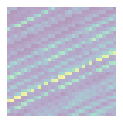

In [137]:
plt.figure(figsize=(2,2))
plt.imshow(map_array, cmap='viridis', interpolation='nearest', alpha=0.4)
plt.axis('off')
# plt.colorbar()
# plt.show()
plt.savefig('heatmap.png')

In [125]:
apportionment = apportionment/sum(apportionment)

apportionment = apportionment*100
print('contrib_brick', round(apportionment[0],2), 'contrib_industry', round(apportionment[1],2),\
      'contrib_population', round(apportionment[2],2), 'contrib_traffic', round(apportionment[3],2))

contrib_brick 0.25 contrib_industry 52.92 contrib_population 46.42 contrib_traffic 0.41


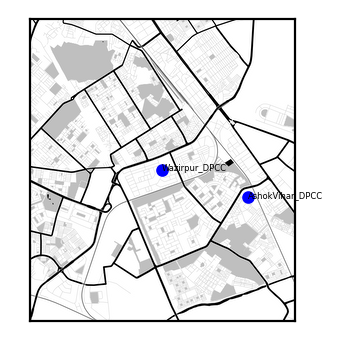

In [126]:
sensor = test[19][1]

coord = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
region_lat_b, region_lat_t, region_long_l, region_long_r = coord[0]-0.025, coord[0]+0.025, coord[1]-0.025, coord[1]+0.025
subset_locs = locs[(locs['Latitude']<region_lat_t) & (locs['Latitude']>region_lat_b) &\
                   (locs['Longitude']<region_long_r) & (locs['Longitude']>region_long_l)]

lat_lims = region_lat_b, region_lat_t
lon_lims = region_long_l, region_long_r
lon_center, lat_center = coord[1], coord[0]

lat_pad = 1.0 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.0 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(2,2), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in subset_locs.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=50, label='Our sensors')
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b', s=50, label='CPCB/DPCC/IMD')
    ax.text(x, y, row.Index, fontsize=3)

# ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)
fig.savefig('hsp_map.png')
# plt.show()

# plt.imshow(map_array, cmap='viridis', interpolation='nearest', alpha=0.4)
# plt.axis('off')

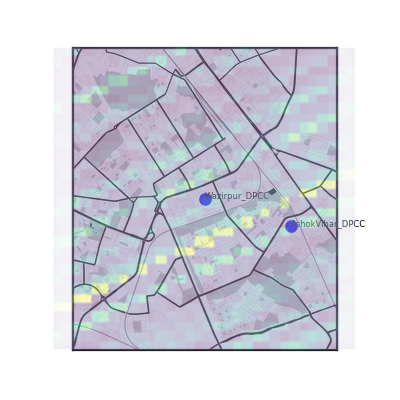

In [127]:
hsp_map = Image.open('./hsp_map.png')
heatmap = Image.open('./heatmap.png')

heatmap = heatmap.resize(hsp_map.size)

hsp_map.paste(heatmap,(0,0),heatmap)

hsp_map